<a href="https://colab.research.google.com/github/bpmasters/asa-challenge-24/blob/main/asa-challenge-24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
import librosa
import scipy
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')
plt.rcParams['figure.figsize'] = (18, 6)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [120]:
# copy of matlab buffer function
def buffer(signal, frame_size, overlap_size=0):
    step_size = frame_size - overlap_size
    total_frames = int(np.ceil(len(signal) / step_size))

    padded_length = total_frames * step_size + overlap_size
    padded_signal = np.append(signal, np.zeros(padded_length - len(signal)))

    frames = np.lib.stride_tricks.sliding_window_view(padded_signal, frame_size)[::step_size]

    return frames

# gcc phase transform
def gccphat(x, y, max_tau, fs):
    n = max(x.shape[0], y.shape[0])
    # x = x*np.hanning(x.shape[0])
    # y = y*np.hanning(y.shape[0])

    max_shift = int(n/2)
    X = np.fft.rfft(x)
    Y = np.fft.rfft(y)
    R = X*np.conj(Y)

    cc = np.fft.irfft(R/(np.abs(R)+ 1e-10))
    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    tau = np.argmax(np.abs(cc)) - max_shift

    return tau, cc

In [121]:
# import data and normalize to -1:1
fs, h1 = scipy.io.wavfile.read('/content/drive/MyDrive/ASA-Challenge-24/HYD1.wav')
_,  h2 = scipy.io.wavfile.read('/content/drive/MyDrive/ASA-Challenge-24/HYD2.wav')
_,  h3 = scipy.io.wavfile.read('/content/drive/MyDrive/ASA-Challenge-24/HYD3.wav')

h1 = h1.astype(np.float32)/np.iinfo(h1.dtype).max
h2 = h2.astype(np.float32)/np.iinfo(h2.dtype).max
h3 = h3.astype(np.float32)/np.iinfo(h3.dtype).max

ts = np.arange(0, len(h1)/fs, 1/fs)

Text(0, 0.5, 'FFT Coefficient [dBFS]')

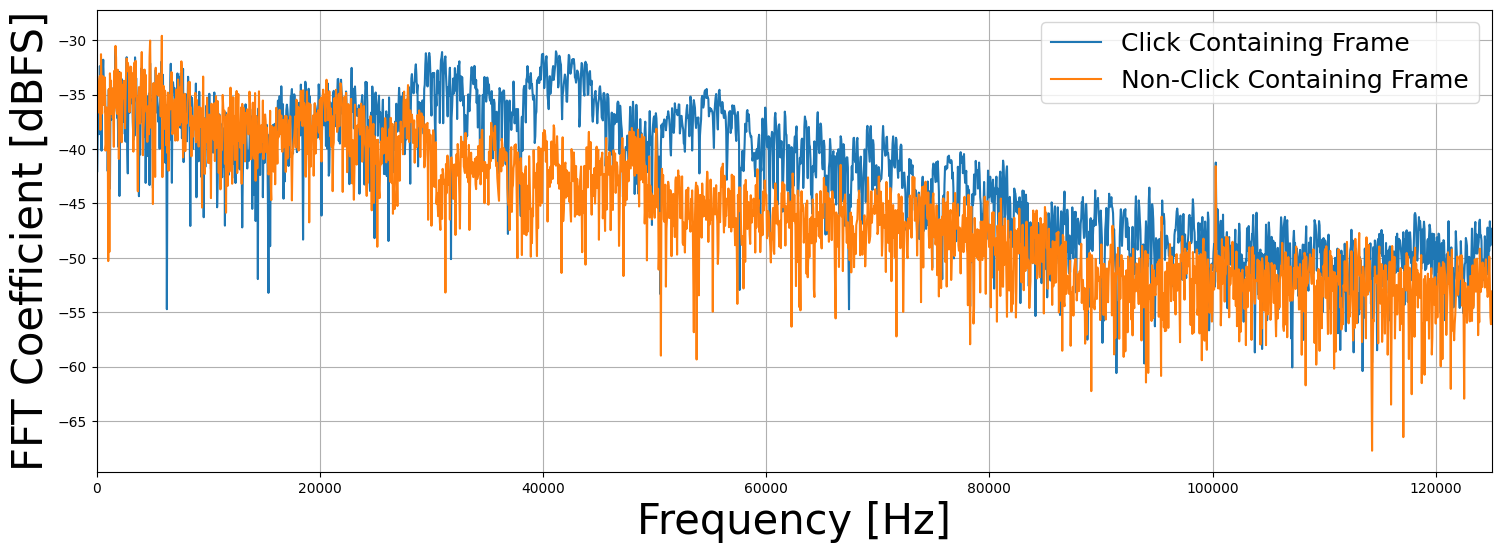

In [122]:
# Plot spectra of hydrophone data during a click and not a click
N = len(h1[int(2.2*fs):int(2.22*fs)])
T = 1/fs
yf = scipy.fftpack.fft(h1[int(2.2*fs):int(2.22*fs)])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 10*np.log10(2.0/N * np.abs(yf[:N//2])), label = 'Click Containing Frame')
plt.xlim(0,125e3)
N = len(h1[int(2.5*fs):int(2.52*fs)])
T = 1/fs
yf = scipy.fftpack.fft(h1[int(2.5*fs):int(2.52*fs)])
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
ax.plot(xf, 10*np.log10(2.0/N * np.abs(yf[:N//2])), label = 'Non-Click Containing Frame')
plt.legend(fontsize=18)
plt.grid()
plt.xlabel('Frequency [Hz]', fontsize = 30)
plt.ylabel('FFT Coefficient [dBFS]', fontsize = 30)

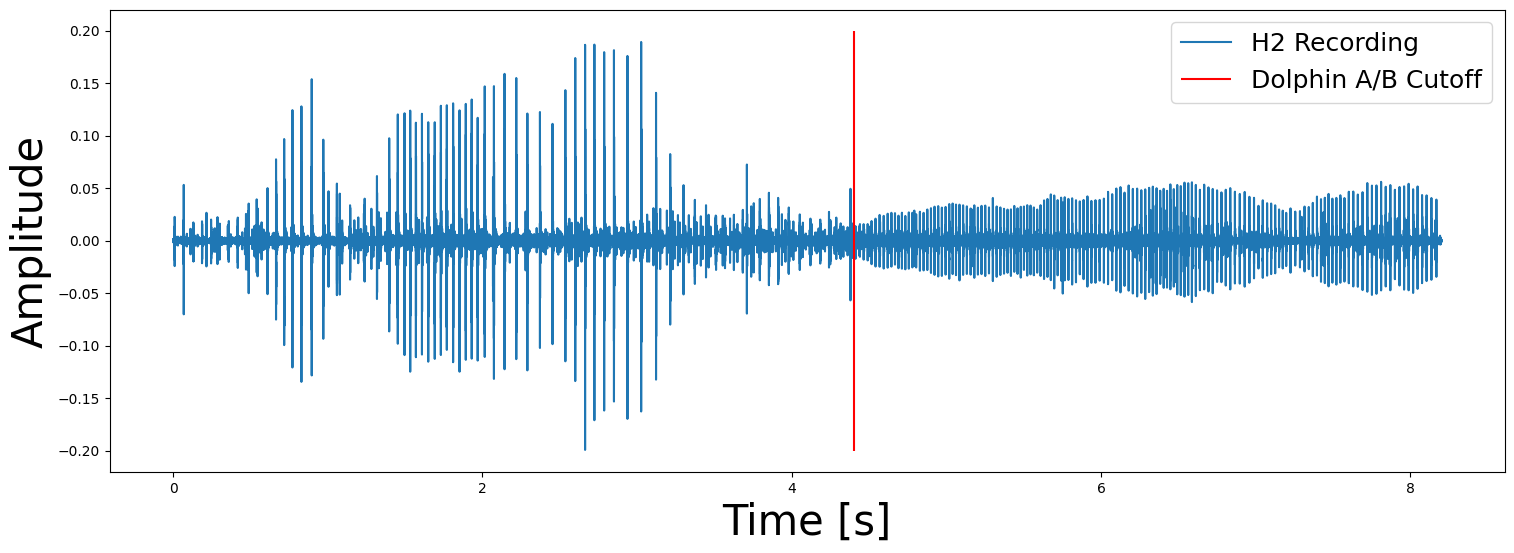

In [123]:
# Develop a bandpass filter based on spectral observations
bpf_l = 25000
bpf_h = 75000
bpf_N = 20
click_cutoff_t = 4.4  # Cutoff time for dolphin A vs. B

# Can verify here using transfer function type filter
[bpf_b, bpf_a] = scipy.signal.butter(bpf_N, [bpf_l, bpf_h], btype='bandpass', fs = fs)
# w, h = scipy.signal.freqz(bpf_b, bpf_a)
# plt.semilogx(w*fs/2/np.pi, 20 * np.log10(abs(h)))

# Implement operation using second order sections for minimal numerical errors
bpf_sos = scipy.signal.butter(bpf_N, [bpf_l, bpf_h], btype='bandpass', fs = fs, output='sos')
h1b = scipy.signal.sosfiltfilt(bpf_sos, h1)
h2b = scipy.signal.sosfiltfilt(bpf_sos, h2)
h3b = scipy.signal.sosfiltfilt(bpf_sos, h3)

plt.figure()
plt.plot(np.arange(0,len(h2b))/fs, h2b, label= 'H2 Recording')
plt.vlines(click_cutoff_t, .2, -.2, 'r', label='Dolphin A/B Cutoff')
plt.xlabel('Time [s]', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
# plt.title('Hydrophone 2 Recording and Selected Dolphin A/B Cutoff Point', fontsize=30)
plt.legend(fontsize=18)

218.75


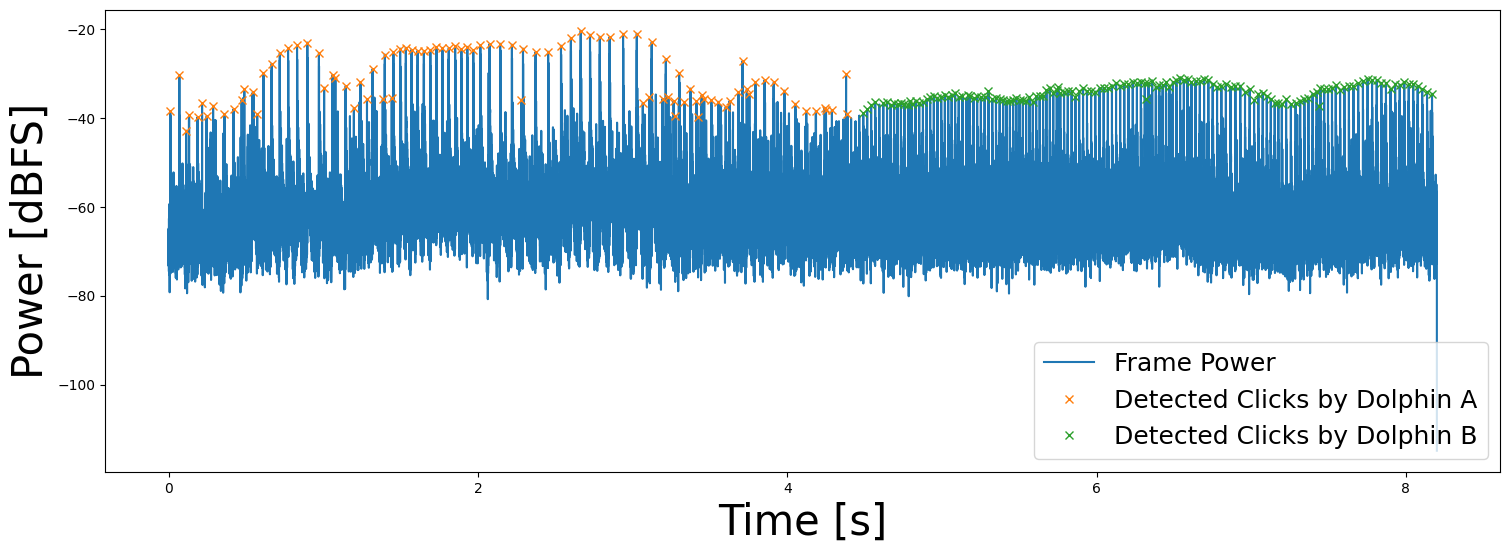

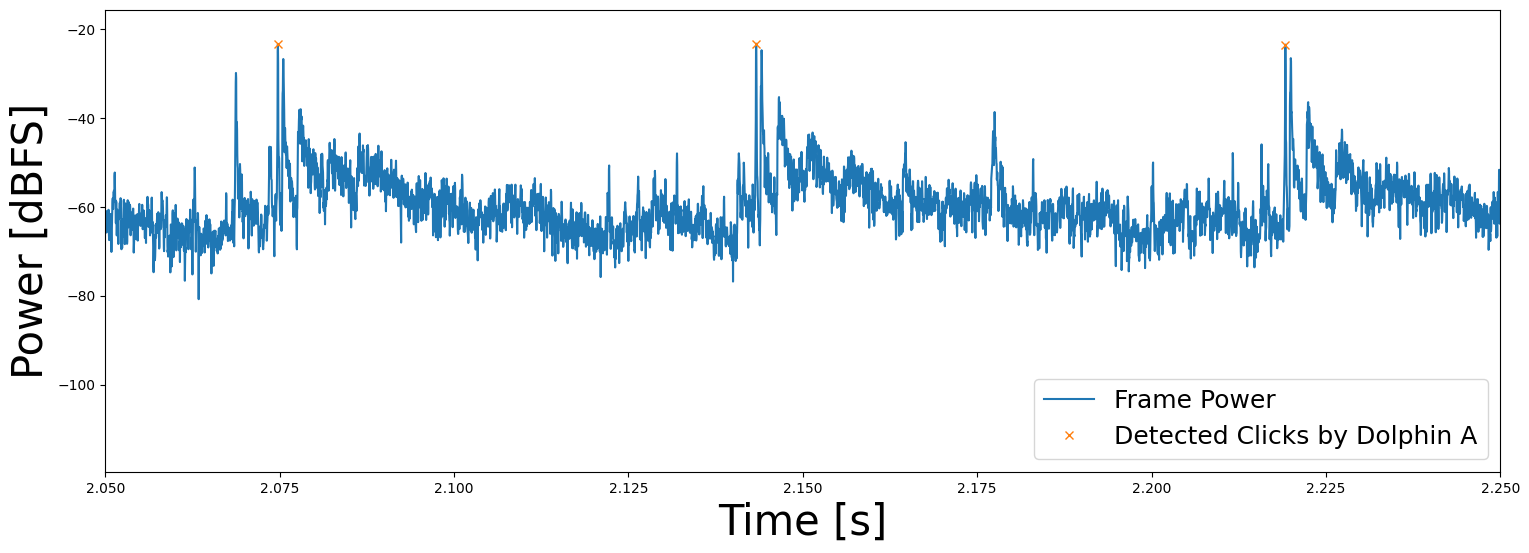

In [124]:
# Analysis Parameters for Simple Click Detection
win_size = 16
noverlap = int(win_size*.5) #np.int(np.ceil(win_size/10)) Use no overlap here for minimal uncertainty
pk_distance = .007 * fs/(win_size-noverlap)  # Distance between peaks, frames based on 7 ms expected ICI
print(pk_distance)
# pk_wlen = 20  # Samples to look around the peak

# Buffer a time signal
ts_buff = buffer(ts, win_size, noverlap)
ts_buff = ts_buff[:,0]

# Buffer the bandpass filtered middle hydrophone signal
h2_buff = buffer(h2b, win_size, noverlap)
h2_buff_pow = 20*np.log10(np.sqrt(np.mean(h2_buff**2,axis=1)))

# Specify parameters for click detection
dB_peak_thresh_a = 35  # Dolphin A threshold
dB_peak_thresh_b = 35  # Dolphin B threshold


# Run prominence based peak detector to find envelope (clicks)
h2_peaks_a, _ = scipy.signal.find_peaks(h2_buff_pow[ts_buff<click_cutoff_t], prominence=dB_peak_thresh_a, distance=pk_distance)
h2_peaks_b, _ = scipy.signal.find_peaks(h2_buff_pow[ts_buff>=click_cutoff_t], prominence=dB_peak_thresh_b, distance=pk_distance)

# Plot the frame by frame power along with the detected click locations
plt.figure()
plt.plot(ts_buff, h2_buff_pow, label='Frame Power')
plt.plot(ts_buff[h2_peaks_a], h2_buff_pow[h2_peaks_a], 'x', label='Detected Clicks by Dolphin A')
plt.plot(ts_buff[ts_buff>=click_cutoff_t][h2_peaks_b], h2_buff_pow[ts_buff>=click_cutoff_t][h2_peaks_b], 'x', label='Detected Clicks by Dolphin B')
plt.xlabel('Time [s]', fontsize = 30)
plt.ylabel('Power [dBFS]', fontsize = 30)
plt.legend(fontsize=18, loc='lower right')
# plt.title(r'Locations of Detected Clicks, Uncertainty = $\pm$' + str(np.round(1000*win_size/fs/2, 3)) + ' ms', fontsize=30)

plt.figure()
plt.plot(ts_buff, h2_buff_pow, label='Frame Power')
plt.plot(ts_buff[h2_peaks_a], h2_buff_pow[h2_peaks_a], 'x', label='Detected Clicks by Dolphin A')
plt.xlim([2.05,2.25])
plt.xlabel('Time [s]', fontsize = 30)
plt.ylabel('Power [dBFS]', fontsize = 30)
plt.legend(fontsize=18, loc='lower right')


Text(0.5, 1.0, 'Locations of Detected Clicks, Uncertainty = $\\pm$0.032 ms')

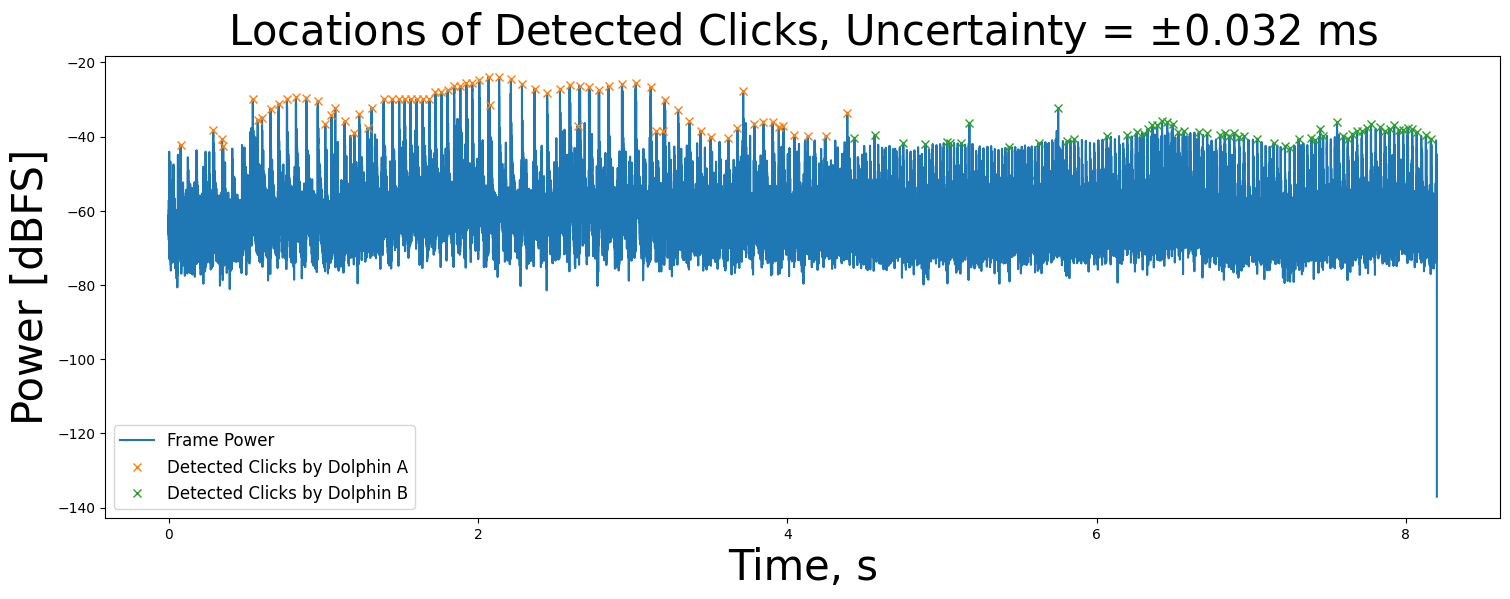

In [125]:

# Analysis Parameters for Simple Click Detection
# Buffer a time signal
ts_buff = buffer(ts, win_size, noverlap)
ts_buff = ts_buff[:,0]

# Buffer the bandpass filtered middle hydrophone signal
h1_buff = buffer(h1b, win_size, noverlap)
h1_buff_pow = 20*np.log10(np.sqrt(np.mean(h1_buff**2,axis=1)))

# Specify parameters for click detection
dB_peak_thresh_a = 35  # Dolphin A threshold
dB_peak_thresh_b = 35  # Dolphin B threshold

# Run prominence based peak detector to find envelope (clicks)
h1_peaks_a, _ = scipy.signal.find_peaks(h1_buff_pow[ts_buff<click_cutoff_t], prominence=dB_peak_thresh_a, distance=pk_distance)
h1_peaks_b, _ = scipy.signal.find_peaks(h1_buff_pow[ts_buff>=click_cutoff_t], prominence=dB_peak_thresh_b, distance=pk_distance)

# Plot the frame by frame power along with the detected click locations
plt.figure()
plt.plot(ts_buff, h1_buff_pow, label='Frame Power')
plt.plot(ts_buff[h1_peaks_a], h1_buff_pow[h1_peaks_a], 'x', label='Detected Clicks by Dolphin A')
plt.plot(ts_buff[ts_buff>=click_cutoff_t][h1_peaks_b], h1_buff_pow[ts_buff>=click_cutoff_t][h1_peaks_b], 'x', label='Detected Clicks by Dolphin B')
plt.xlabel('Time, s', fontsize = 30)
plt.ylabel('Power [dBFS]', fontsize = 30)
plt.legend(fontsize=12)
plt.title(r'Locations of Detected Clicks, Uncertainty = $\pm$' + str(np.round(1000*win_size/fs/2, 3)) + ' ms', fontsize=30)


Text(0.5, 1.0, 'Locations of Detected Clicks, Uncertainty = $\\pm$16.0 $\\mu$s')

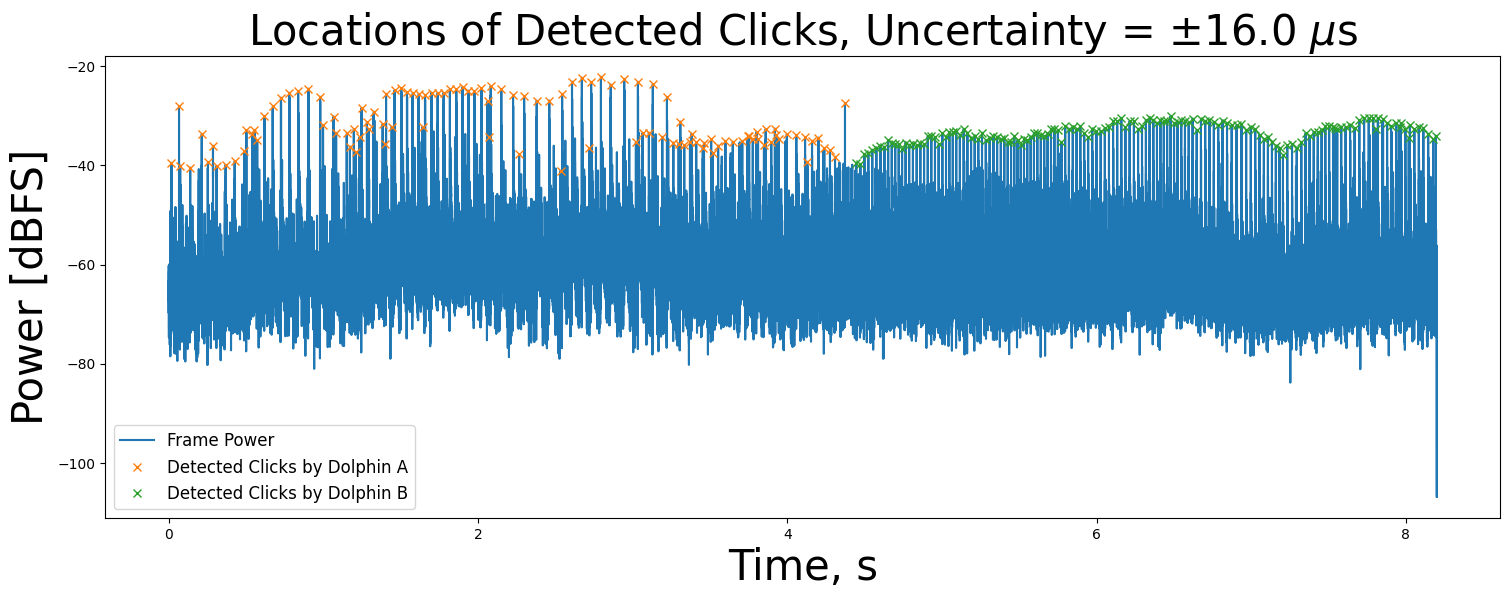

In [126]:
# Analysis Parameters for Simple Click Detection
# Buffer a time signal
ts_buff = buffer(ts, win_size, noverlap)
ts_buff = ts_buff[:,0]

# Buffer the bandpass filtered middle hydrophone signal
h3_buff = buffer(h3b, win_size, noverlap)
h3_buff_pow = 20*np.log10(np.sqrt(np.mean(h3_buff**2,axis=1)))

# Specify parameters for click detection
dB_peak_thresh_a = 35  # Dolphin A threshold
dB_peak_thresh_b = 35  # Dolphin B threshold

# Run prominence based peak detector to find envelope (clicks)
h3_peaks_a, _ = scipy.signal.find_peaks(h3_buff_pow[ts_buff<click_cutoff_t], prominence=dB_peak_thresh_a, distance=pk_distance)
h3_peaks_b, _ = scipy.signal.find_peaks(h3_buff_pow[ts_buff>=click_cutoff_t], prominence=dB_peak_thresh_b, distance=pk_distance)

# Plot the frame by frame power along with the detected click locations
plt.figure()
plt.plot(ts_buff, h3_buff_pow, label='Frame Power')
plt.plot(ts_buff[h3_peaks_a], h3_buff_pow[h3_peaks_a], 'x', label='Detected Clicks by Dolphin A')
plt.plot(ts_buff[ts_buff>=click_cutoff_t][h3_peaks_b], h3_buff_pow[ts_buff>=click_cutoff_t][h3_peaks_b], 'x', label='Detected Clicks by Dolphin B')
plt.xlabel('Time, s', fontsize = 30)
plt.ylabel('Power [dBFS]', fontsize = 30)
plt.legend(fontsize=12)
plt.title(r'Locations of Detected Clicks, Uncertainty = $\pm$' + str(np.round(1000000*(win_size-noverlap)/fs/2, 0)) + r' $\mu$s', fontsize=30)


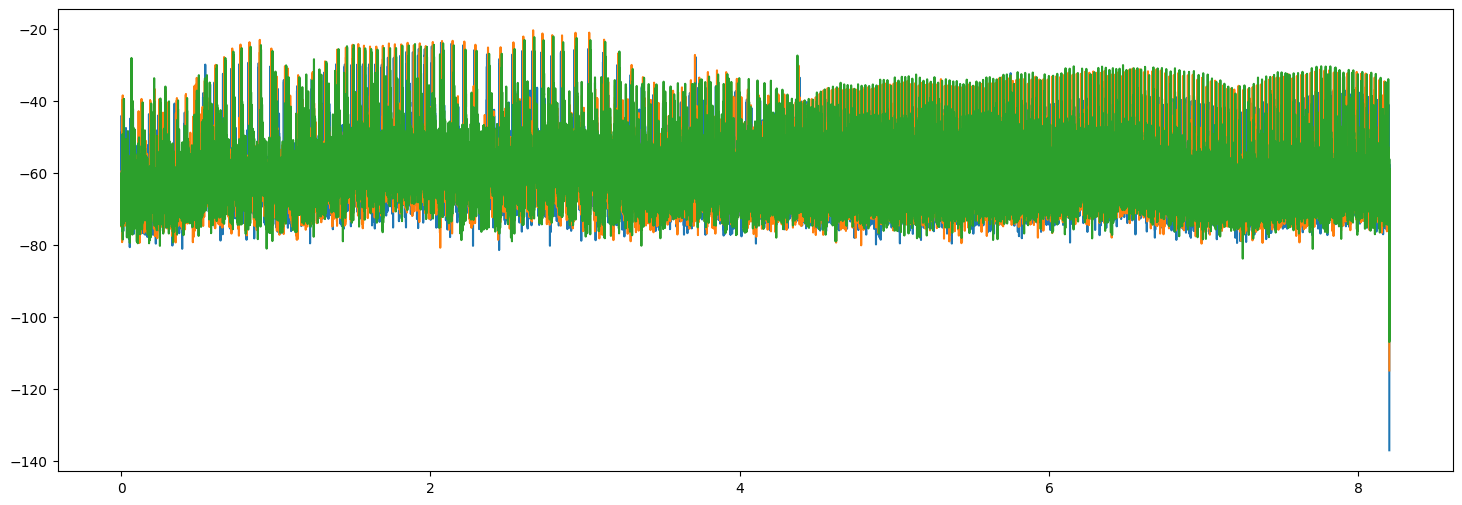

In [127]:
plt.figure()
plt.plot(ts_buff, h1_buff_pow, label='Frame Power')
plt.plot(ts_buff, h2_buff_pow, label='Frame Power')
plt.plot(ts_buff, h3_buff_pow, label='Frame Power')

In [128]:
print(len(h1_peaks_a))
print(len(h2_peaks_a))
print(len(h3_peaks_a))

print(len(h1_peaks_b))
print(len(h2_peaks_b))
print(len(h3_peaks_b))

73
97
115
61
148
152


In [129]:
remove_inds = []
for i, peak in enumerate(h2_peaks_a):
  # only run gcc if theres peaks in both other hydrophones
  if not ((np.abs(h1_peaks_a - peak) < win_width).any() and (np.abs(h3_peaks_a - peak) < win_width).any()):
    remove_inds.append(i)

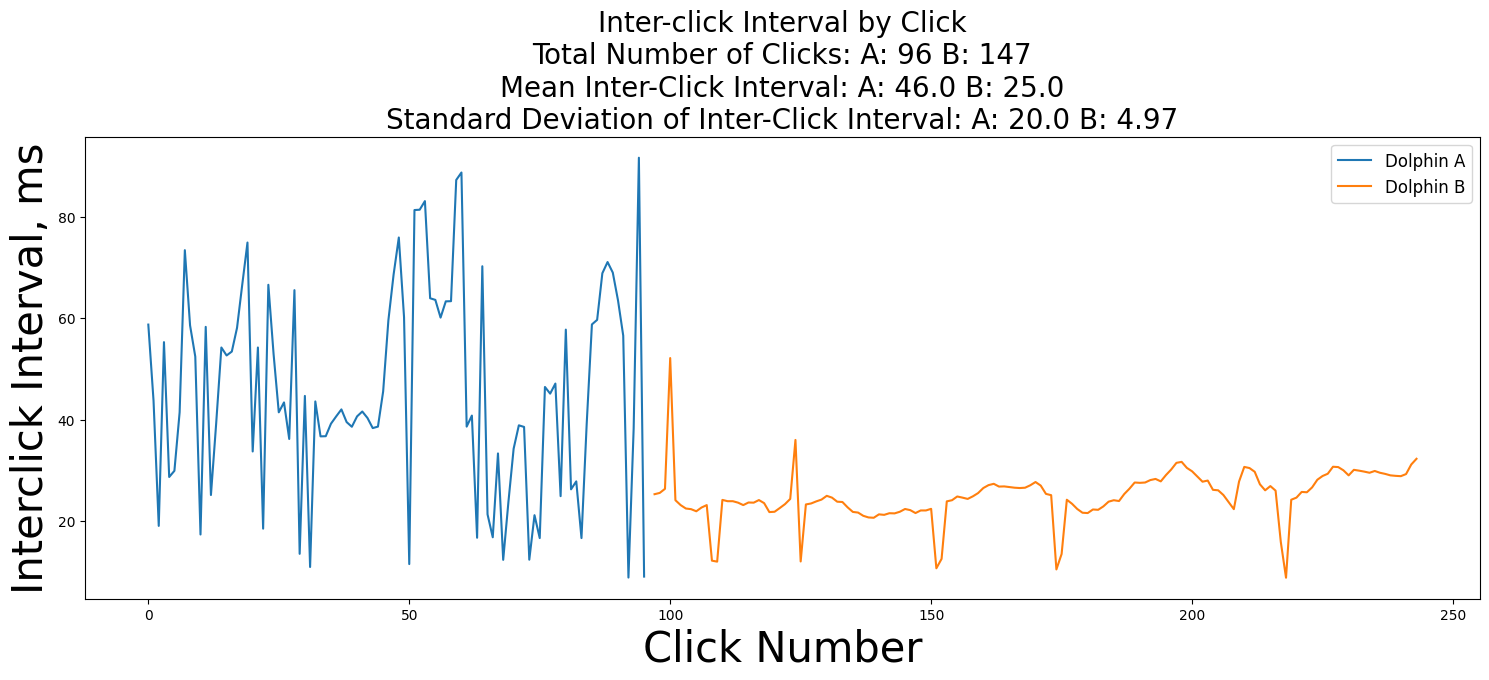

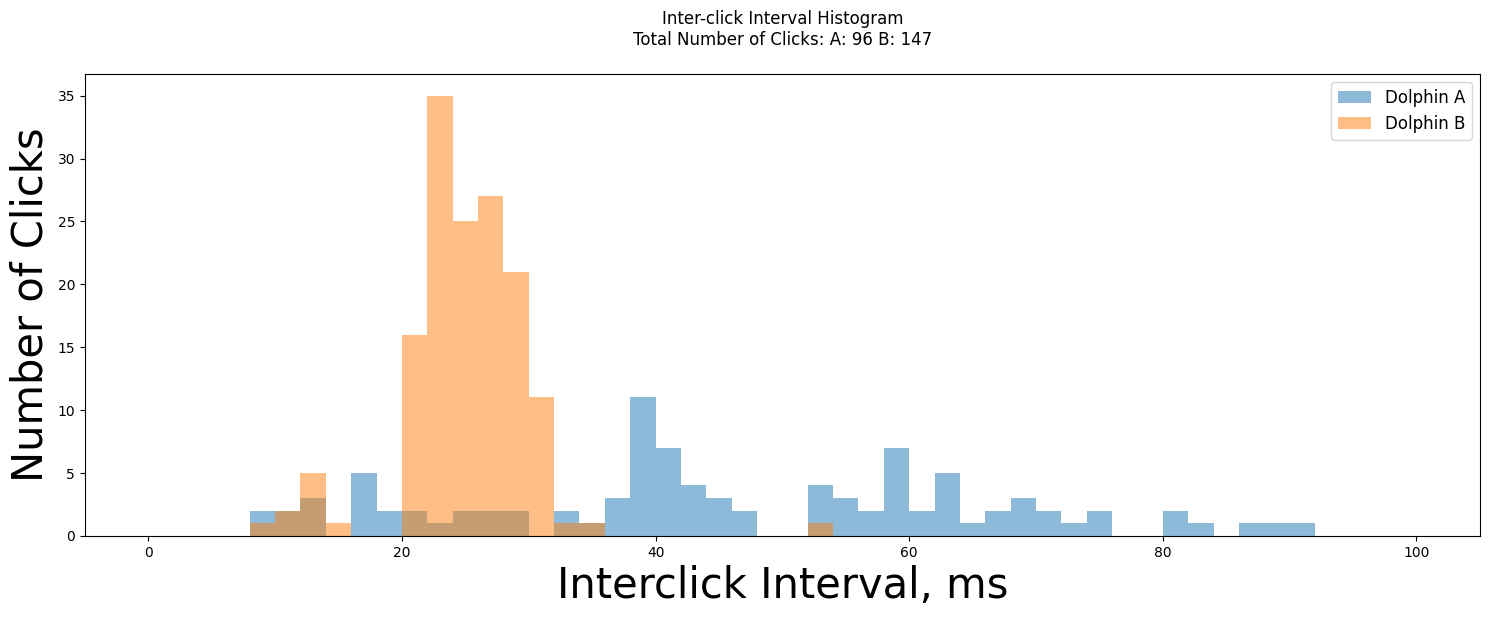

In [130]:
click_cutoff = click_cutoff_t/(len(h2)/fs)

ts_buff_a = ts_buff[0:np.int16(np.floor(click_cutoff*len(ts_buff)))]
h2_buff_pow_a = h2_buff_pow[0:np.int16(np.floor(click_cutoff*len(h2_buff_pow)))]
h2_clicks_a = h2_buff_pow[h2_peaks_a]
h2_click_ts_a = ts_buff[h2_peaks_a]

ts_buff_b = ts_buff[np.int16(np.ceil(click_cutoff*len(ts_buff))):]
h2_buff_pow_b = h2_buff_pow[np.int16(np.ceil(click_cutoff*len(h2_buff_pow))):]
h2_clicks_b = h2_buff_pow[h2_peaks_b]
h2_click_ts_b = ts_buff[h2_peaks_b]

# Plotting the interclick interval by click number, along with some statistics
ici_a = np.diff(h2_click_ts_a)*1000
ici_b = np.diff(h2_click_ts_b)*1000

plt.figure()
plt.plot(np.arange(0,len(ici_a)), ici_a, label='Dolphin A')
plt.plot(np.arange(len(ici_a)+1,len(ici_b)+len(ici_a)+1), ici_b, label='Dolphin B')
plt.ylabel('Interclick Interval, ms', fontsize = 30)
plt.xlabel('Click Number', fontsize = 30)
plt.title('Inter-click Interval by Click' + '\n' + 'Total Number of Clicks: ' + 'A: ' + str(len(ici_a)) + ' B: ' + str(len(ici_b)) + '\n'
          + 'Mean Inter-Click Interval: A: ' + str(np.round(np.mean(ici_a))) + ' B: ' + str(np.round(np.mean(ici_b))) + '\n'
          + 'Standard Deviation of Inter-Click Interval: A: ' + str(np.round(np.std(ici_a))) + ' B: ' + str(np.round(np.std(ici_b),2)), fontsize = 20)
plt.legend(fontsize=12)

plt.figure()
plt.hist(ici_a, bins=np.linspace(0,100,51), alpha=0.5, label='Dolphin A')
plt.hist(ici_b, bins=np.linspace(0,100,51), alpha=0.5, label='Dolphin B')
plt.xlabel('Interclick Interval, ms', fontsize = 30)
plt.ylabel('Number of Clicks', fontsize = 30)
plt.title('Inter-click Interval Histogram' + '\n' + 'Total Number of Clicks: ' + 'A: ' + str(len(ici_a)) + ' B: ' + str(len(ici_b)) + '\n')
plt.legend(fontsize=12)

# print(np.linspace(0,100,21))

##TASK 2

In [131]:
d = 14  # meters, separating hydrophones
c = 1520  # m/s, speed of sound in water
max_td = d/c

# win_size = 4096
# noverlap = int(np.ceil(win_size*.99))

dB_peak_thresh_a = 25
dB_peak_thresh_b = 20
pk_distance = 5
click_cutoff = int(click_cutoff_t * fs)

print(max_td)

0.009210526315789473


### Dolphin A

16
287
8
1959


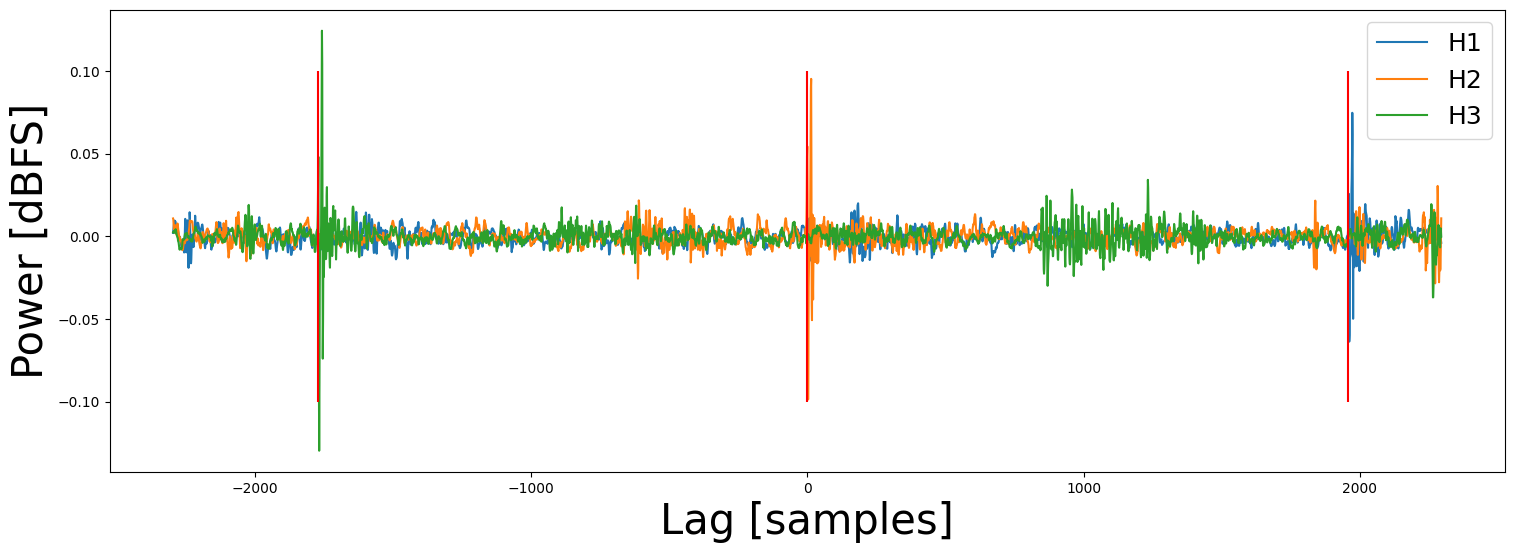

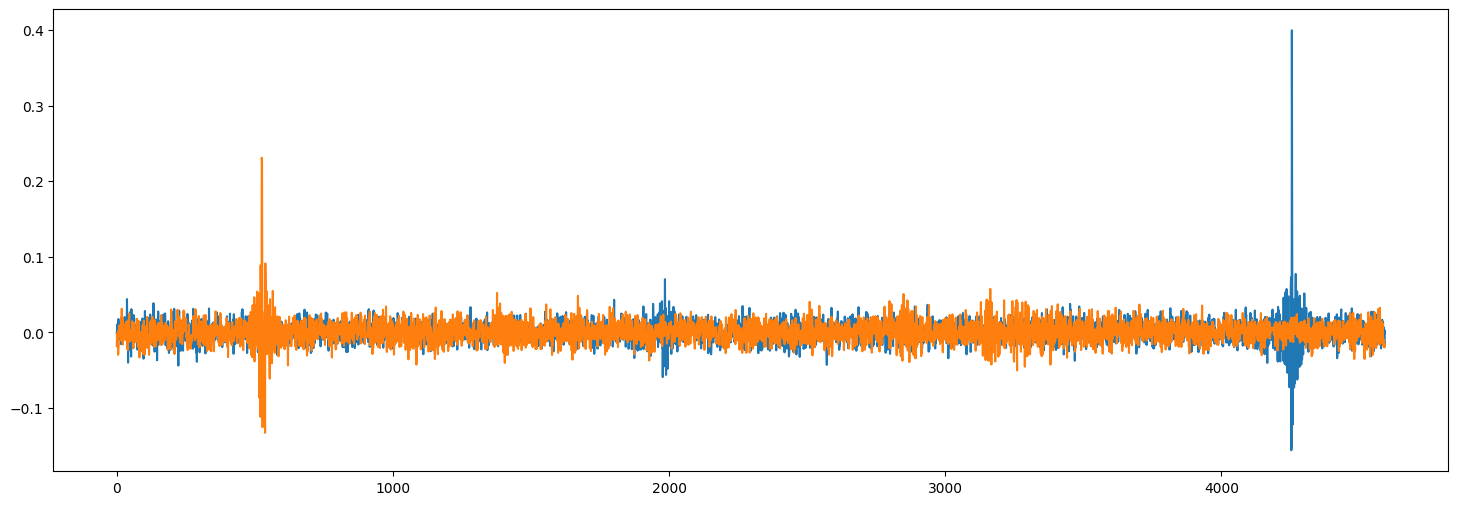

In [162]:
# Better idea:

lags_12 = []
lags_23 = []

win_width = int(np.ceil(max_td*fs)/(win_size-noverlap))
frame_to_sample = win_size-noverlap
print(win_size)
print(win_width)
print(frame_to_sample)
for i, peak in enumerate(h2_peaks_a):
  # only run gcc if theres peaks in both other hydrophones
  if (np.abs(h1_peaks_a - peak) < win_width).any() and (np.abs(h3_peaks_a - peak) < win_width).any():

    post_win = win_width
    pre_win = win_width

    non_win_loc = peak
    # h1_sig = h1_buff_pow[non_win_loc-pre_win:non_win_loc+post_win]
    # h2_sig = h2_buff_pow[non_win_loc-pre_win:non_win_loc+post_win]
    # h3_sig = h3_buff_pow[non_win_loc-pre_win:non_win_loc+post_win]

    h1_sig = h1[frame_to_sample*(non_win_loc-pre_win):frame_to_sample*(non_win_loc+post_win)]
    h2_sig = h2[frame_to_sample*(non_win_loc-pre_win):frame_to_sample*(non_win_loc+post_win)]
    h3_sig = h3[frame_to_sample*(non_win_loc-pre_win):frame_to_sample*(non_win_loc+post_win)]

    # h1_sig = h1_sig*np.hanning(len(h1_sig))
    # h2_sig = h2_sig*np.hanning(len(h2_sig))
    # h3_sig = h3_sig*np.hanning(len(h3_sig))

    lag_12, cc_12 = gccphat(h1_sig, h2_sig, max_td, fs)
    lag_23, cc_23 = gccphat(h3_sig, h2_sig, max_td, fs)

    lags_12.append(lag_12)
    lags_23.append(lag_23)

plt.figure()
plt.plot(-len(h1_sig)/2+np.arange(0,len(h1_sig)), h1_sig, label='H1')
plt.plot(-len(h2_sig)/2+np.arange(0,len(h2_sig)), h2_sig, label='H2')
plt.plot(-len(h3_sig)/2+np.arange(0,len(h3_sig)), h3_sig, label='H3')
# plt.vlines(0, -70, -40, 'r')
# plt.vlines(lag_12, -70, -40, 'r')
# plt.vlines(abs(lag_23), -70, -40, 'r')

plt.vlines(0, -.1, .1, 'r')
plt.vlines(lag_12, -.1, .1, 'r')
plt.vlines(lag_23, -.1, .1, 'r')
plt.xlabel('Lag [samples]', fontsize = 30)
plt.ylabel('Power [dBFS]', fontsize = 30)
plt.legend(fontsize=18)

# plt.figure()
# plt.plot(lags_12)
# plt.plot(lags_23)

print(lag_12)

plt.figure()
plt.plot(cc_12)
plt.plot(cc_23)
# np.argmax(np.abs(cc_12))


-1116.1515151515152 -1283.121212121212
1268.3306881956757 1054.0363042904012
-0.9079250859755121
-0.929393392526142
-1.2808756660549658
-1.3391779551937284


(0.0, 20.0)

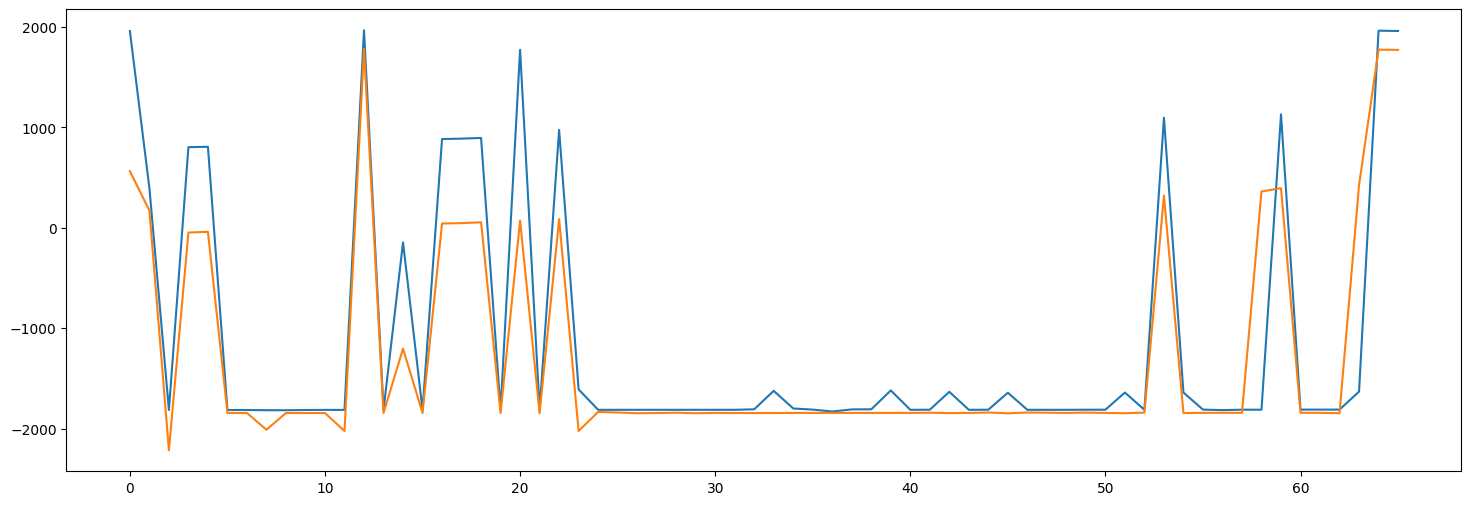

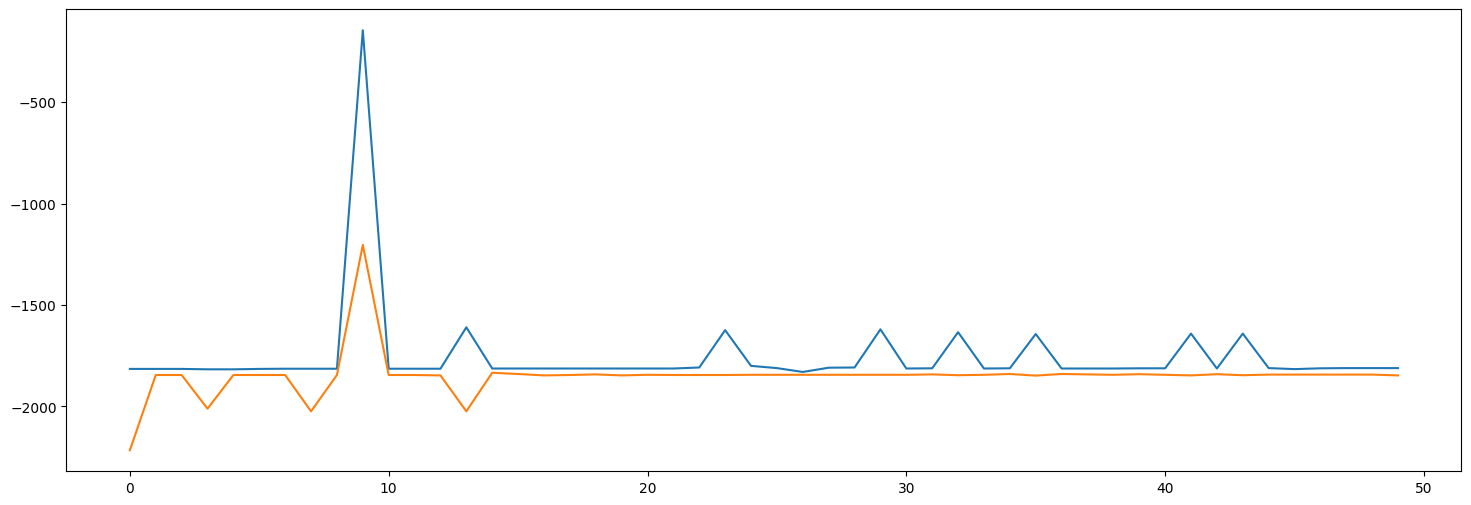

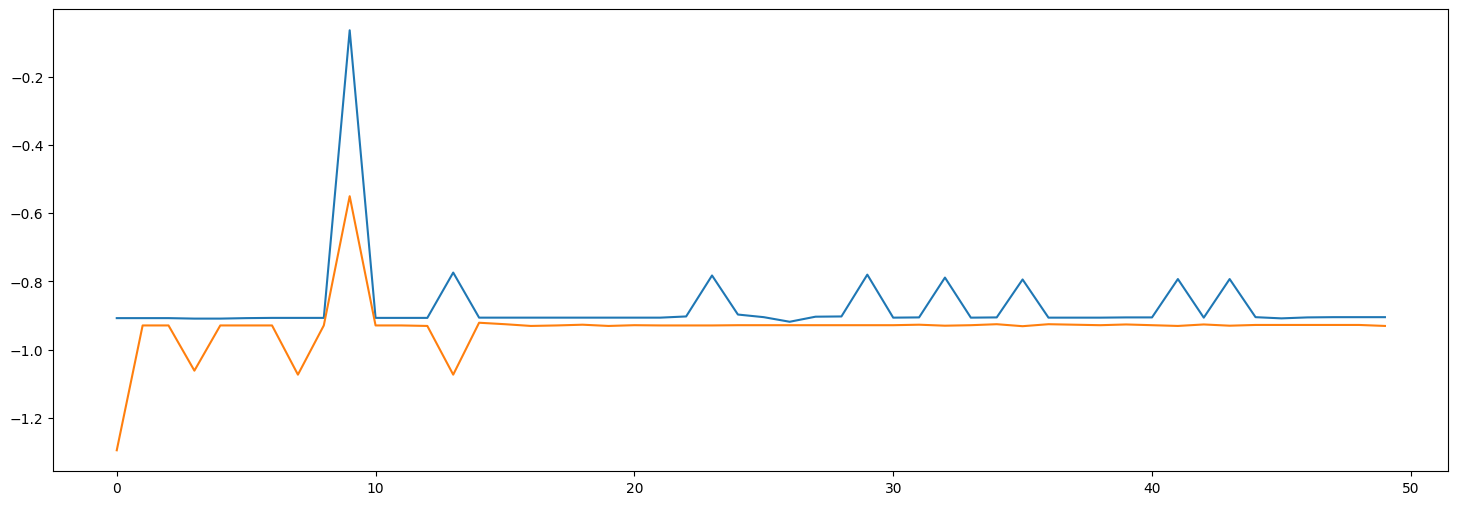

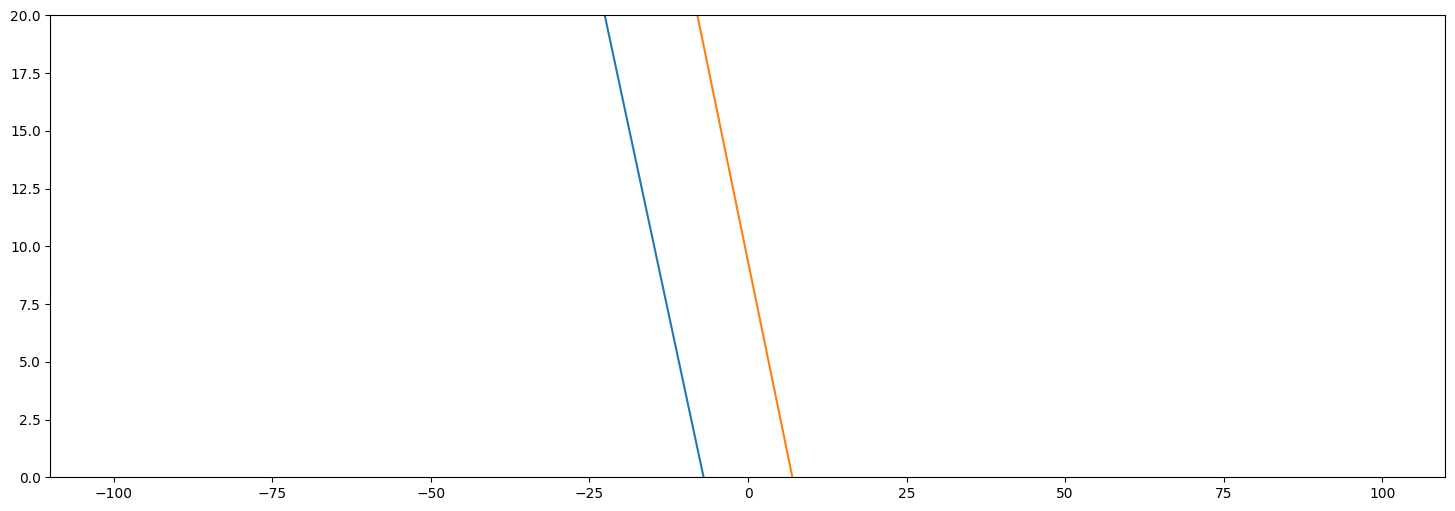

In [163]:
lags_12 = np.array(lags_12)
lags_23 = -np.array(lags_23)

plt.figure()
plt.plot(lags_12)
plt.plot(lags_23)

print(np.mean(lags_12), np.mean(lags_23))
print(np.std(lags_12), np.std(lags_23))

good_inds = (np.abs(lags_23 - np.mean(lags_23)) < np.std(lags_23)) & (np.abs(lags_12 - np.mean(lags_12)) < np.std(lags_12))
filt_lags_12 = lags_12[good_inds]
filt_lags_23 = lags_23[good_inds]

plt.figure()
plt.plot(filt_lags_12)
plt.plot(filt_lags_23)

angles_12 = np.arcsin(filt_lags_12/(fs*max_td))
angles_23 = np.arcsin(filt_lags_23/(fs*max_td))

plt.figure()
plt.plot(angles_12)
plt.plot(angles_23)

slopes_12 = np.tan(angles_12)
slopes_23 = np.tan(angles_23)

x = np.arange(-100,100,.01)
rays_12 = np.ndarray([len(angles_12), len(x)])
rays_23 = np.ndarray([len(angles_23), len(x)])

for i, a in enumerate(angles_12):
  rays_12[i, :] = slopes_12[i]*(x+7)

for i, a in enumerate(angles_23):
  rays_23[i, :] = slopes_23[i]*(x-7)

plt.figure()
print(angles_12[1])
print(angles_23[1])
print(slopes_12[1])
print(slopes_23[1])
plt.plot(x, rays_12[-5, :])
plt.plot(x, rays_23[-5, :])
plt.ylim([0, 20])

### Dolphin B

16
287


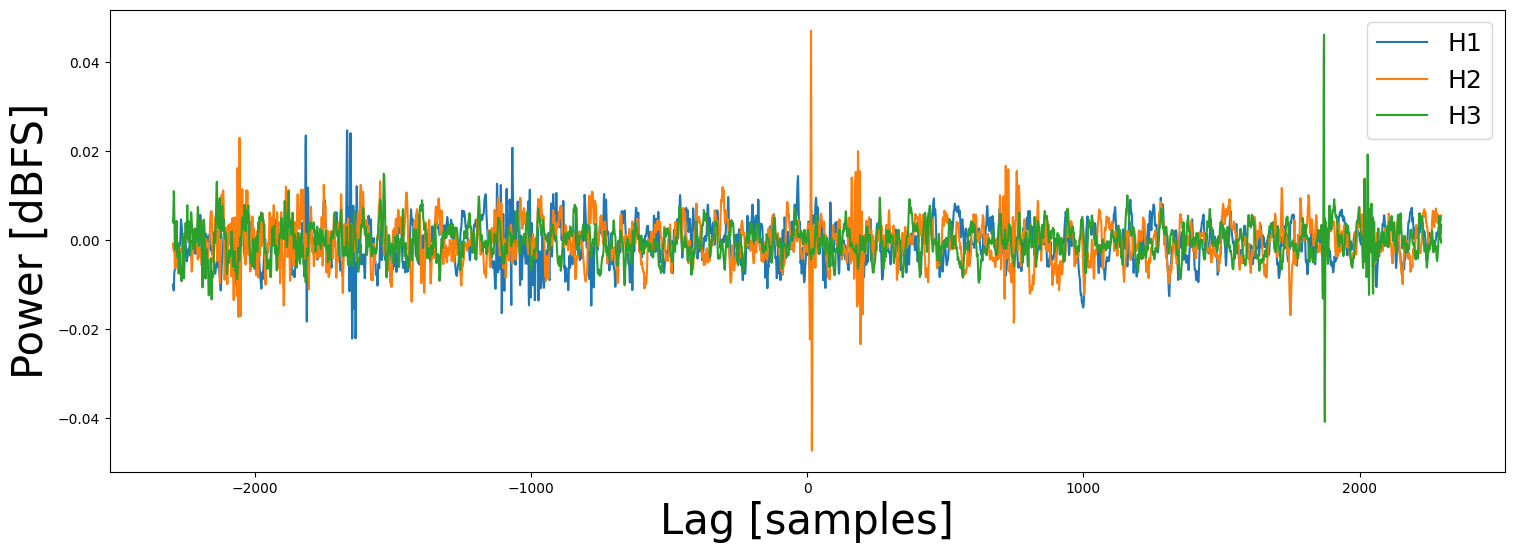

In [180]:
# Dolphin B

lags_12 = []
lags_23 = []

win_width = int(np.ceil(max_td*fs)/(win_size-noverlap))
frame_to_sample = win_size-noverlap
print(win_size)
print(win_width)
for i, peak in enumerate(h2_peaks_b):
  # only run gcc if theres peaks in both other hydrophones
  if (np.abs(h1_peaks_b - peak) < win_width).any() and (np.abs(h3_peaks_b - peak) < win_width).any():
    non_win_loc = peak + int(click_cutoff_t*fs/(win_size-noverlap))#*frame_to_sample


    post_win = win_width
    pre_win = win_width

    # h1_sig = h1_buff_pow[non_win_loc-pre_win:non_win_loc+post_win]
    # h2_sig = h2_buff_pow[non_win_loc-pre_win:non_win_loc+post_win]
    # h3_sig = h3_buff_pow[non_win_loc-pre_win:non_win_loc+post_win]

    h1_sig = h1[frame_to_sample*(non_win_loc-pre_win):frame_to_sample*(non_win_loc+post_win)]
    h2_sig = h2[frame_to_sample*(non_win_loc-pre_win):frame_to_sample*(non_win_loc+post_win)]
    h3_sig = h3[frame_to_sample*(non_win_loc-pre_win):frame_to_sample*(non_win_loc+post_win)]

    # h1_sig = h1_sig*np.hanning(len(h1_sig))
    # h2_sig = h2_sig*np.hanning(len(h2_sig))
    # h3_sig = h3_sig*np.hanning(len(h3_sig))

    lag_12, cc_12 = gccphat(h1_sig, h2_sig, max_td, fs)
    lag_23, cc_23 = gccphat(h3_sig, h2_sig, max_td, fs)

    lags_12.append(lag_12)
    lags_23.append(lag_23)

plt.figure()
plt.plot(-len(h1_sig)/2+np.arange(0,len(h1_sig)), h1_sig, label='H1')
plt.plot(-len(h2_sig)/2+np.arange(0,len(h2_sig)), h2_sig, label='H2')
plt.plot(-len(h3_sig)/2+np.arange(0,len(h3_sig)), h3_sig, label='H3')
# plt.vlines(0, -70, -40, 'r')
# plt.vlines(lag_12, -70, -40, 'r')
# plt.vlines(abs(lag_23), -70, -40, 'r')
plt.xlabel('Lag [samples]', fontsize = 30)
plt.ylabel('Power [dBFS]', fontsize = 30)
plt.legend(fontsize=18)



-1181.75 -1650.45
1164.4362817117417 790.0088696759466
[-1.3996741  -0.9185838  -0.9178686  -0.91572703 -0.81393434 -0.81583368
  1.08946022 -0.80386819 -0.81267024 -0.81267024 -0.14732089 -0.91715408
 -0.81267024 -0.78711539 -0.48524247 -0.02692897 -0.81330208  0.93888986
 -0.72270667  0.18431031  1.29883433 -0.43100363  1.09228201 -0.13153323
 -0.11271854 -0.91715408 -0.91715408 -0.91715408 -0.9150145  -0.80825908
 -0.9150145  -0.91715408 -0.9150145  -0.91715408 -0.9150145  -0.91644022
 -0.9150145  -0.9150145  -0.91715408 -0.19005641 -0.19005641 -0.91715408
  1.01004757 -0.80012044 -0.91715408  0.70204816 -0.91715408 -0.80012044
 -0.81077723 -0.80012044 -0.80136808 -0.81203882 -0.81203882 -0.9178686
 -0.80012044 -0.91644022 -0.80136808 -0.81203882 -0.79825199 -0.91644022]


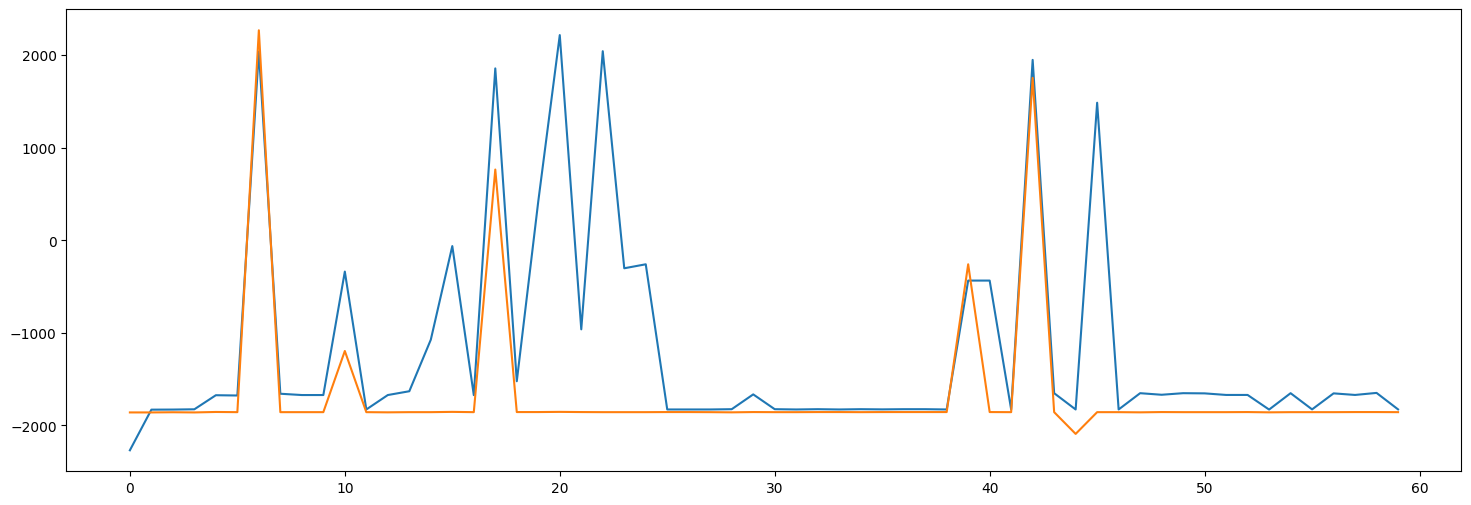

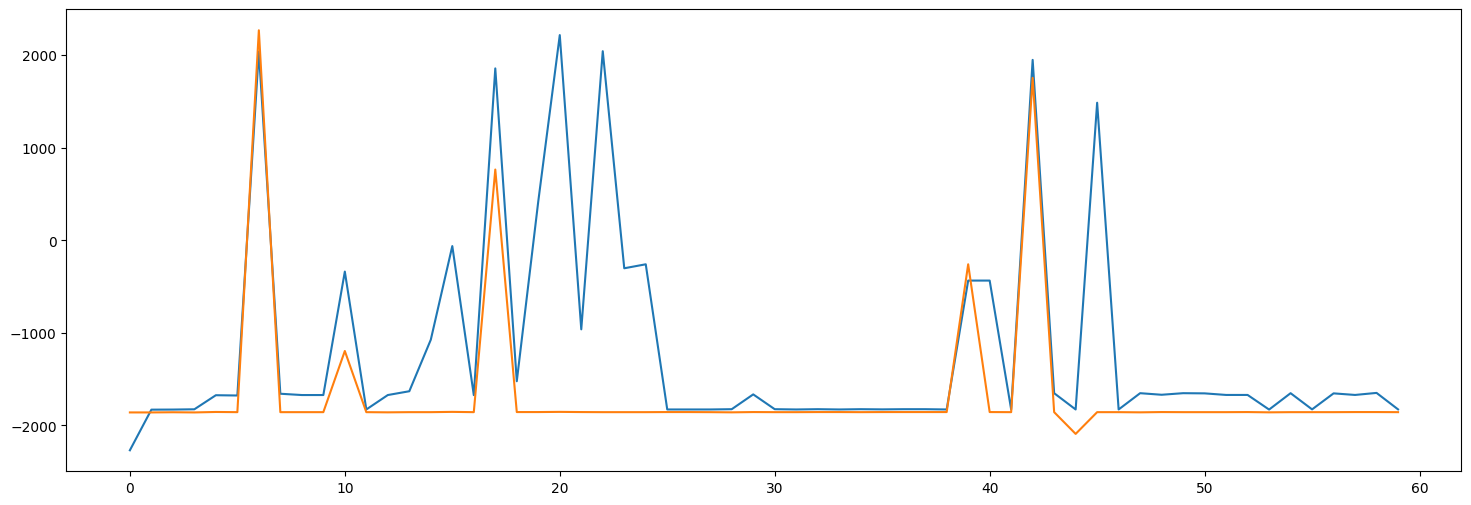

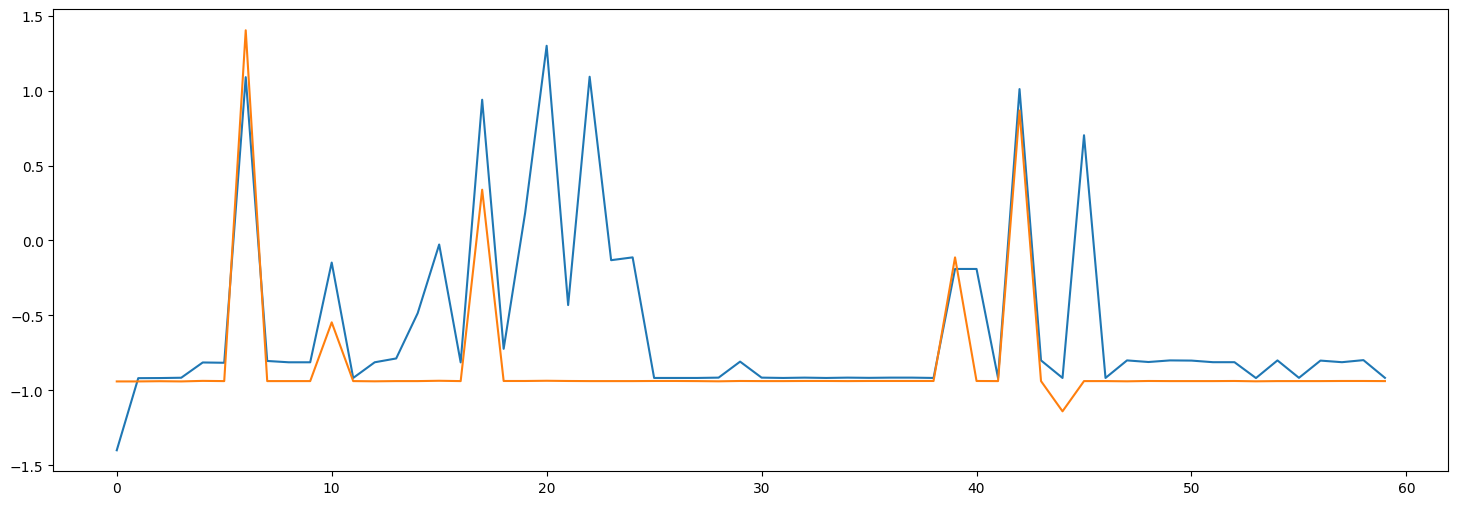

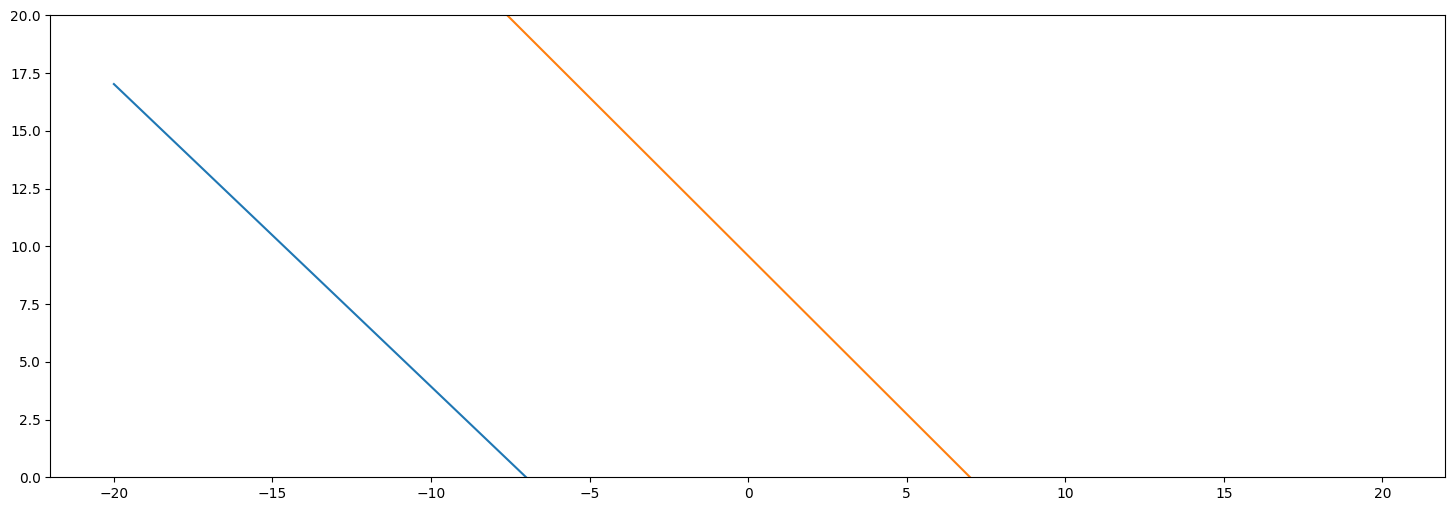

In [181]:
lags_12 = np.array(lags_12)
lags_23 = -np.array(lags_23)


plt.figure()
plt.plot(lags_12)
plt.plot(lags_23)

print(np.mean(lags_12), np.mean(lags_23))
print(np.std(lags_12), np.std(lags_23))
good_inds = (np.abs(lags_23 - np.mean(lags_23)) < np.std(lags_23)) & (np.abs(lags_12 - np.mean(lags_12)) < np.std(lags_12))
filt_lags_12 = lags_12#[good_inds]
filt_lags_23 = lags_23#[good_inds]
# filt_lags_12 = lags_12[np.abs(lags_12 - np.mean(lags_12)) < np.std(lags_12)]
# filt_lags_23 = lags_23[np.abs(lags_23 - np.mean(lags_23)) < np.std(lags_23)]

plt.figure()
plt.plot(filt_lags_12)
plt.plot(filt_lags_23)

angles_12 = np.arcsin(filt_lags_12/(fs*max_td))
angles_23 = np.arcsin(filt_lags_23/(fs*max_td))

plt.figure()
plt.plot(angles_12)
plt.plot(angles_23)

slopes_12 = np.tan(angles_12)
slopes_23 = np.tan(angles_23)

x = np.arange(-20,20,.01)
rays_12 = np.ndarray([len(angles_12), len(x)])
rays_23 = np.ndarray([len(angles_23), len(x)])

for i, a in enumerate(angles_12):
  rays_12[i, :] = slopes_12[i]*(x+7)

for i, a in enumerate(angles_23):
  rays_23[i, :] = slopes_23[i]*(x-7)

plt.figure()
plt.plot(x, rays_12[1, :])
plt.plot(x, rays_23[1, :])
plt.ylim([0, 20])
print(angles_12)

In [107]:
print(len(h1_peaks_a))
print(len(h2_peaks_a))
print(len(h3_peaks_a))

74
99
117
